# Setting the OpenAI Key as an Environment Variable

In [1]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

# Importing Relevant Classes and functions

In [2]:
# Library Import
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.runnables import Runnable
from langchain_core.messages import HumanMessage, BaseMessage
from collections.abc import Sequence

# Define the State
class State(TypedDict):
    message: list[BaseMessage]

# Define Chat Model
chat = ChatOpenAI(model='gpt-4',
                  seed= 25,
                  max_completion_tokens= 100,
                  temperature=0
)

# Define Node
def chatbot(state: State) -> State:
    # print(f"\n---------> Entering Chatbot")
    AI_message = chat.invoke(state['message'])
    AI_message.pretty_print()

    return State(message = [AI_message])

# Initial State
state = State(
    message = [
        HumanMessage("Could you let me know what is the best time to visit kolkata ?")
    ]
)
state['message'][0].pretty_print()

# Test node directly
# new_state = chatbot(state)

# Define Graph (typed)
graph : StateGraph[State] = StateGraph(State)
graph.add_node('chatbot', chatbot)
graph.add_edge(START, 'chatbot')
graph.add_edge('chatbot', END)

graph_compiled = graph.compile()

# Invoke Graph
final_state = graph_compiled.invoke(state)

================================ Human Message =================================

Could you let me know what is the best time to visit kolkata ?
================================== Ai Message ==================================

The best time to visit Kolkata, India is during the cooler months from October to March. This period sees a lot of cultural activities like music festivals, art exhibitions, and theater. The famous Durga Puja festival, which is a major attraction, is held in October. The weather during these months is pleasant and comfortable for sightseeing.


In [5]:
# Library Import
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.runnables import Runnable
from langchain_core.messages import HumanMessage, BaseMessage
from collections.abc import Sequence
from langgraph.pregel import Pregel

# Define the State
class State(TypedDict):
    message: Sequence[BaseMessage]

# Define Chat Model
chat = ChatOpenAI(model='gpt-4',
                  seed= 25,
                  max_completion_tokens= 100,
                  temperature=0
)

# Define Node 1
def ask_question(state: State) -> State:
    print(f"\n---------> Entering ask_question")
    print("What is your question ?")
    return State(message = [HumanMessage(input())])

# Define Node 2
def chatbot(state: State) -> State:
    print(f"\n---------> Entering Chatbot")
    AI_message = chat.invoke(state['message'])
    AI_message.pretty_print()

    return State(message = [AI_message])

# Define Node 3
def ask_another_question(state: State) -> State:
    print(f"\n------------------> Entering ask_another_question")
    print("Would you like to ask one more question (yes/no) ?")
    return State(message = [HumanMessage(input())])

# Routing Function
def routing_function(state: State) -> str:
    if(state['message'][0].content == 'yes'):
        return 'True'
    else:
        return 'False'

# Define the graph
graph = StateGraph(State)

# Adding the nodes
graph.add_node('ask_question', ask_question)
graph.add_node('chatbot', chatbot)
graph.add_node('ask_another_question', ask_another_question)

# Adding edges
graph.add_edge(START, 'ask_question')
graph.add_edge('ask_question', 'chatbot')
graph.add_edge('chatbot', 'ask_another_question')
graph.add_conditional_edges(source='ask_another_question', path=routing_function, path_map={'True':'ask_question', 'False': '__end__'})

# compile the graph
graph_compiled = graph.compile()

# Test the graph
graph_compiled.invoke(State(message=[]))


---------> Entering ask_question
What is your question ?


 What is best time to visit Darjeeling ?



---------> Entering Chatbot
================================== Ai Message ==================================

The best time to visit Darjeeling is from April to June when the weather is pleasant and the temperature ranges from 20-25 degrees Celsius. This is the perfect time for sightseeing and outdoor activities. Another good time to visit is from October to March when the weather is cool and clear, offering stunning views of the surrounding mountains. However, it can get quite cold in the winter months, especially in December and January.

------------------> Entering ask_another_question
Would you like to ask one more question (yes/no) ?


 yes



---------> Entering ask_question
What is your question ?


 How to go there from Delhi ?



---------> Entering Chatbot
================================== Ai Message ==================================

As an AI, I need to know the destination you're asking about in order to provide accurate directions. Could you please specify where you want to go from Delhi?

------------------> Entering ask_another_question
Would you like to ask one more question (yes/no) ?


 no


{'message': [HumanMessage(content='no', additional_kwargs={}, response_metadata={})]}

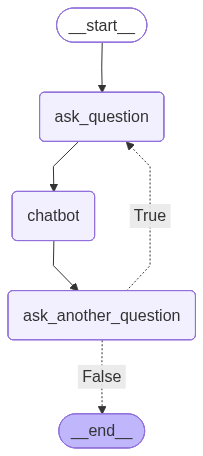

In [6]:
graph_compiled